In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
SEED=1234

In [58]:
# Funcion para graficar las curvas de entrenamiento y de validacion
import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [16]:
# Cargar el conjunto de datos
datos = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial/Temp_Asu20092021.csv')

In [17]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

In [18]:
# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

In [19]:
# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

In [20]:
# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

In [21]:
# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

In [22]:
# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

In [90]:
# Seleccionar características (por ejemplo,buscar variables adicionales)
X = percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

In [24]:
# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

In [25]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

In [26]:
# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = 1
    tf.keras.utils.set_random_seed(SEED)

    num_capas = 1
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])


    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

In [91]:
# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=100)

[I 2024-09-11 21:17:39,193] A new study created in memory with name: no-name-209e6328-3208-461a-87a2-9a32cfc9419f
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-11 21:17:42,369] Trial 0 finished with value: 20.4274845123291 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-11 21:17:46,420] Trial 1 finished with value: 20.4274845123291 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-11 21:17:49,070] Trial 2 finished with value: 21.93014144897461 and parameters: {'num_unidades': 16}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-11 21:17:51,872] Trial 3 finished with value: 20.4274845123291 and pa

In [92]:
# Obtener los mejores hiperparámetros
mejor_num_capas =  1
mejor_num_unidades = estudio.best_params['num_unidades']
print("Mejores Hiperparámetros:")
print("Número de Capas:", 1)
print("Número de Unidades:", mejor_num_unidades)

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 64


In [93]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['mae'])

In [94]:
# Entrenar el modelo final
history=modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 629.9698 - mae: 23.9944 - val_loss: 588.8467 - val_mae: 22.9064
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 627.0723 - mae: 23.9342 - val_loss: 586.0829 - val_mae: 22.8439
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 624.1583 - mae: 23.8735 - val_loss: 583.2867 - val_mae: 22.7806
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 621.2073 - mae: 23.8120 - val_loss: 580.4520 - val_mae: 22.7162
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 618.2095 - mae: 23.7494 - val_loss: 577.5688 - val_mae: 22.6506
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 615.1569 - mae: 23.6855 - val_loss: 574.6271 - val_mae: 22.5834
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 612.0364 - mae: 23.6200 - val_loss: 571.6180 - val_mae: 22.5145
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 608.8347 - mae: 23.5526 - val_loss: 568.5306 - val_mae: 22.4434
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━

In [95]:
# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

MAE en validación: [336.5521240234375, 16.443742752075195]


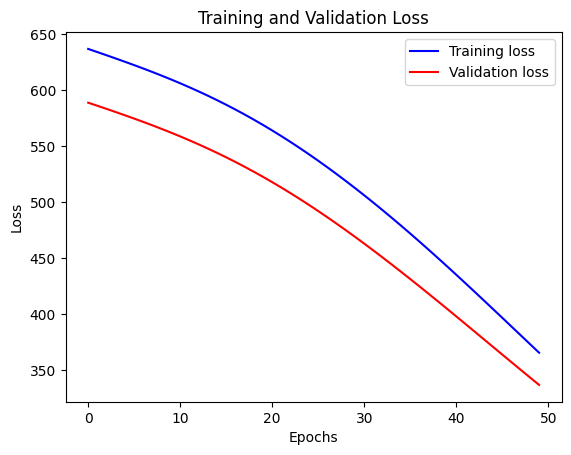

In [96]:
visualize_loss(history, "Training and Validation Loss")

In [116]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mae',
                     metrics=['mse'])

In [117]:
# Entrenar el modelo final
history=modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 23.9832 - mse: 629.8868 - val_loss: 22.8730 - val_mse: 587.7679
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.9242 - mse: 627.1221 - val_loss: 22.8111 - val_mse: 585.1466
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.8646 - mse: 624.3372 - val_loss: 22.7481 - val_mse: 582.4857
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.8039 - mse: 621.5032 - val_loss: 22.6839 - val_mse: 579.7673
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.7419 - mse: 618.6022 - val_loss: 22.6180 - val_mse: 576.9761
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.6782 - mse: 615.6217 - val_loss: 22.5502 - val_mse: 574.1050
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.6125 - mse: 612.5515 - val_loss: 22.4802 - val_mse: 571.1456
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.5446 - mse: 609.3837 - val_loss: 22.4077 - val_mse: 568.0877
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━

In [118]:
# Evaluar en conjunto de prueba
mse = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MSE en validación: {mse}')

MSE en validación: [16.17474937438965, 324.0836181640625]


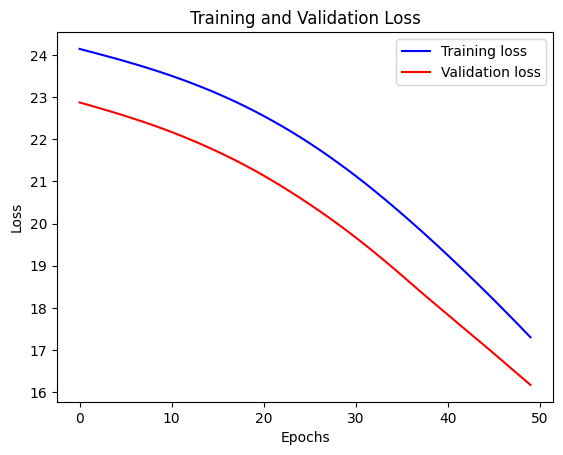

In [119]:
visualize_loss(history, "Training and Validation Loss")